In [1]:
import pandas as pd
import os
from os import listdir
from scipy.signal import butter, lfilter
import librosa as lb
import soundfile as sf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
diag_csv = 'respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diag_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [3]:
ds = diagnosis['diagnosis'].unique()
ds

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [4]:
audio_text_loc = 'respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_loc) if '.txt' in s]
files

['176_2b3_Pr_mc_AKGC417L',
 '211_2p4_Tc_mc_AKGC417L',
 '198_6p1_Pr_mc_AKGC417L',
 '130_1p4_Ar_mc_AKGC417L',
 '130_3p2_Ar_mc_AKGC417L',
 '130_2b2_Ll_mc_AKGC417L',
 '204_7p5_Tc_mc_AKGC417L',
 '205_2b3_Ar_mc_AKGC417L',
 '138_1p4_Pl_mc_AKGC417L',
 '107_2b5_Ar_mc_AKGC417L',
 '166_1p1_Al_sc_Meditron',
 '132_2b2_Lr_mc_LittC2SE',
 '138_2p2_Al_mc_AKGC417L',
 '161_1b1_Al_sc_Meditron',
 '138_2p2_Pl_mc_AKGC417L',
 '174_1p3_Ll_mc_AKGC417L',
 '117_1b3_Tc_mc_LittC2SE',
 '166_1p1_Ar_sc_Meditron',
 '202_1b1_Ar_sc_Meditron',
 '133_3p2_Al_mc_AKGC417L',
 '218_1b1_Lr_sc_Meditron',
 '163_8b3_Al_mc_AKGC417L',
 '137_1b1_Ar_sc_Meditron',
 '226_1b1_Pl_sc_LittC2SE',
 '138_1p4_Ll_mc_AKGC417L',
 '178_1b3_Lr_mc_AKGC417L',
 '138_1p2_Pl_mc_AKGC417L',
 '151_3p2_Pr_mc_AKGC417L',
 '123_1b1_Al_sc_Meditron',
 '172_1b4_Tc_mc_AKGC417L',
 '160_1b4_Pl_mc_AKGC417L',
 '176_1b4_Ll_mc_AKGC417L',
 '154_3b3_Ar_mc_AKGC417L',
 '135_2b3_Tc_mc_LittC2SE',
 '158_1p2_Pr_mc_AKGC417L',
 '203_2p3_Pl_mc_AKGC417L',
 '175_1b1_Ll_sc_Litt3200',
 

In [5]:
def tokenize_file(filename):
    return filename.split('_')

In [6]:
files_ = []
for f in files:
    df = pd.read_csv(audio_text_loc + '/' + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['filename'] = f
    #get filename features
    f_features = tokenize_file(f)
    df['pId'] = f_features[0]
    df['ac_mode'] = f_features[3]
    
    files_.append(df)
    
files_df = pd.concat(files_)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode
0,0.093,1.785,0,0,176_2b3_Pr_mc_AKGC417L,176,mc
1,1.785,5.085,1,0,176_2b3_Pr_mc_AKGC417L,176,mc
2,5.085,7.995,1,0,176_2b3_Pr_mc_AKGC417L,176,mc
3,7.995,11.193,1,0,176_2b3_Pr_mc_AKGC417L,176,mc
4,11.193,14.256,1,0,176_2b3_Pr_mc_AKGC417L,176,mc


In [7]:
files_df['pId'] = files_df['pId'].astype('int64')
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 4
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   filename  6898 non-null   object 
 5   pId       6898 non-null   int64  
 6   ac_mode   6898 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 431.1+ KB


In [8]:
files_df = pd.merge(files_df, diagnosis, on='pId')
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode,diagnosis
0,0.093,1.785,0,0,176_2b3_Pr_mc_AKGC417L,176,mc,COPD
1,1.785,5.085,1,0,176_2b3_Pr_mc_AKGC417L,176,mc,COPD
2,5.085,7.995,1,0,176_2b3_Pr_mc_AKGC417L,176,mc,COPD
3,7.995,11.193,1,0,176_2b3_Pr_mc_AKGC417L,176,mc,COPD
4,11.193,14.256,1,0,176_2b3_Pr_mc_AKGC417L,176,mc,COPD


In [9]:
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [12]:
#os.makedirs('data_coding3')
os.makedirs('data_coding3/output')

In [14]:
for d in ds:
    path = os.path.join('data_coding3/output', d)
    os.makedirs(path)

In [15]:
for f in files:
  aud_loc = audio_text_loc + '/' + f + '.wav'
  data, samplingrate = lb.load(aud_loc, sr=None)
  print(len(data), samplingrate, f)


882000 44100 176_2b3_Pr_mc_AKGC417L
882000 44100 211_2p4_Tc_mc_AKGC417L
882000 44100 198_6p1_Pr_mc_AKGC417L
882000 44100 130_1p4_Ar_mc_AKGC417L
882000 44100 130_3p2_Ar_mc_AKGC417L
882000 44100 130_2b2_Ll_mc_AKGC417L
882000 44100 204_7p5_Tc_mc_AKGC417L
882000 44100 205_2b3_Ar_mc_AKGC417L
882000 44100 138_1p4_Pl_mc_AKGC417L
882000 44100 107_2b5_Ar_mc_AKGC417L
248200 4000 166_1p1_Al_sc_Meditron
882000 44100 132_2b2_Lr_mc_LittC2SE
882000 44100 138_2p2_Al_mc_AKGC417L
882000 44100 161_1b1_Al_sc_Meditron
882000 44100 138_2p2_Pl_mc_AKGC417L
882000 44100 174_1p3_Ll_mc_AKGC417L
882000 44100 117_1b3_Tc_mc_LittC2SE
248200 4000 166_1p1_Ar_sc_Meditron
873180 44100 202_1b1_Ar_sc_Meditron
882000 44100 133_3p2_Al_mc_AKGC417L
330000 4000 218_1b1_Lr_sc_Meditron
882000 44100 163_8b3_Al_mc_AKGC417L
882000 44100 137_1b1_Ar_sc_Meditron
882000 44100 226_1b1_Pl_sc_LittC2SE
882000 44100 138_1p4_Ll_mc_AKGC417L
882000 44100 178_1b3_Lr_mc_AKGC417L
882000 44100 138_1p2_Pl_mc_AKGC417L
882000 44100 151_3p2_Pr_mc_AKGC

882000 44100 192_2b1_Ar_mc_LittC2SE
882000 44100 132_2b1_Lr_mc_LittC2SE
882000 44100 221_2b3_Al_mc_LittC2SE
882000 44100 130_2b3_Al_mc_AKGC417L
882000 44100 193_1b4_Lr_mc_AKGC417L
882000 44100 178_1b6_Pr_mc_AKGC417L
882000 44100 130_2b3_Pl_mc_AKGC417L
882000 44100 133_2p3_Ar_mc_AKGC417L
882000 44100 130_2b4_Al_mc_AKGC417L
112320 4000 218_1p1_Pr_sc_Litt3200
882000 44100 163_8b3_Pl_mc_AKGC417L
882000 44100 177_2b4_Al_mc_AKGC417L
882000 44100 164_1b1_Ll_sc_Meditron
882000 44100 178_1b3_Tc_mc_AKGC417L
882000 44100 137_1b1_Ll_sc_Meditron
882000 44100 154_4b4_Pr_mc_AKGC417L
882000 44100 186_3b3_Lr_mc_AKGC417L
72896 4000 124_1b1_Ll_sc_Litt3200
882000 44100 163_2b2_Lr_mc_AKGC417L
882000 44100 172_1b5_Tc_mc_AKGC417L
882000 44100 203_1p2_Tc_mc_AKGC417L
64960 4000 139_1b1_Pr_sc_Litt3200
882000 44100 186_2b4_Pl_mc_AKGC417L
882000 44100 138_1p2_Pr_mc_AKGC417L
882000 44100 130_3p3_Tc_mc_AKGC417L
882000 44100 207_2b4_Tc_mc_AKGC417L
267000 4000 120_1b1_Al_sc_Meditron
882000 44100 158_2p3_Tc_mc_AKGC417

882000 44100 130_1p4_Pl_mc_AKGC417L
882000 44100 207_2b4_Pr_mc_AKGC417L
882000 44100 146_2b4_Ar_mc_AKGC417L
94912 4000 104_1b1_Pr_sc_Litt3200
882000 44100 154_1b3_Ar_mc_AKGC417L
882000 44100 151_3p2_Pl_mc_AKGC417L
882000 44100 221_2b2_Ar_mc_LittC2SE
882000 44100 172_1b3_Tc_mc_AKGC417L
882000 44100 163_2b2_Pl_mc_AKGC417L
882000 44100 114_1b4_Lr_mc_AKGC417L
882000 44100 186_3b3_Pr_mc_AKGC417L
882000 44100 172_2b5_Al_mc_AKGC417L
882000 44100 184_1b1_Ar_sc_Meditron
882000 44100 178_1b2_Pl_mc_AKGC417L
882000 44100 107_2b5_Ll_mc_AKGC417L
882000 44100 126_1b1_Al_sc_Meditron
882000 44100 162_2b4_Lr_mc_AKGC417L
882000 44100 178_1b6_Ar_mc_AKGC417L
882000 44100 200_2p3_Lr_mc_AKGC417L
882000 44100 162_1b2_Lr_mc_AKGC417L
882000 44100 186_2b4_Lr_mc_AKGC417L
882000 44100 200_2p2_Pl_mc_AKGC417L
882000 44100 186_2b2_Pl_mc_AKGC417L
882000 44100 221_2b2_Lr_mc_LittC2SE
882000 44100 170_1b2_Ar_mc_AKGC417L
120000 4000 195_1b1_Pr_sc_Litt3200
882000 44100 160_1b4_Pr_mc_AKGC417L
267000 4000 120_1b1_Ar_sc_Medit

882000 44100 158_1p3_Lr_mc_AKGC417L
882000 44100 203_1p3_Pl_mc_AKGC417L
86720 4000 175_1b1_Pl_sc_Litt3200
882000 44100 197_1b1_Al_sc_Meditron
882000 44100 219_2b2_Tc_mc_LittC2SE
882000 44100 162_2b3_Ar_mc_AKGC417L
882000 44100 147_2b4_Al_mc_AKGC417L
120000 4000 109_1b1_Pr_sc_Litt3200
882000 44100 172_1b3_Ll_mc_AKGC417L
882000 44100 219_2b1_Tc_mc_LittC2SE
882000 44100 177_2b4_Tc_mc_AKGC417L
882000 44100 101_1b1_Al_sc_Meditron
79808 4000 109_1b1_Ar_sc_Litt3200
882000 44100 176_1b3_Pr_mc_AKGC417L
882000 44100 172_1b5_Ll_mc_AKGC417L
882000 44100 130_2b3_Lr_mc_AKGC417L
882000 44100 147_2b4_Ll_mc_AKGC417L
882000 44100 107_2b4_Lr_mc_AKGC417L
49856 4000 118_1b1_Pr_sc_Litt3200
882000 44100 176_2b3_Ar_mc_AKGC417L
882000 44100 165_1b1_Pl_sc_Meditron
882000 44100 134_2b1_Ar_mc_LittC2SE
882000 44100 177_1b2_Pl_mc_AKGC417L
882000 44100 130_2b4_Lr_mc_AKGC417L
882000 44100 147_1b3_Tc_mc_AKGC417L
882000 44100 158_1p4_Pl_mc_AKGC417L
882000 44100 167_1b1_Al_sc_Meditron
882000 44100 135_2b3_Al_mc_LittC2SE

In [16]:
i = 0 #iterator for file naming
lowcut = 50.0
highcut = 2500.0
order = 6

for idx, row in files_df.iterrows():
    filename = row['filename']
    start = row['start']
    end = row['end']
    diag = row['diagnosis']
    
    if 6 < end - start:
        end = start + 6
      
    aud_loc = audio_text_loc + '/' + f + '.wav'
      
    if idx != 0:
        if files_df.iloc[idx-1]['filename'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = 'data_coding3/output/' + diag + '/' + n_filename
      
    print('processing ' + n_filename + '...')

    data, samplingrate = lb.load(aud_loc)

    #filtering
    nyq = 0.5 * samplingrate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)

    sliced_data = slice_data(start=start, end=end, raw_data=y, sample_rate=samplingrate)
      
    #pad audio if < forced_max_len
    a_len = samplingrate*6
    #a_len = compute_len(samp_rate=samplingrate, acquisition_mode=row['ac_mode']=='sc')
    padded_data = lb.util.pad_center(sliced_data, a_len)

    norm_y = padded_data/ np.abs(padded_data).max()
    #rint(a_len,samplingrate)
    sf.write(file=path, data=norm_y, samplerate=samplingrate)

print("FINISH....")

processing 176_2b3_Pr_mc_AKGC417L_0.wav...
processing 176_2b3_Pr_mc_AKGC417L_1.wav...
processing 176_2b3_Pr_mc_AKGC417L_2.wav...
processing 176_2b3_Pr_mc_AKGC417L_3.wav...
processing 176_2b3_Pr_mc_AKGC417L_4.wav...
processing 176_2b3_Pr_mc_AKGC417L_5.wav...
processing 176_2b3_Pr_mc_AKGC417L_6.wav...
processing 176_1b4_Ll_mc_AKGC417L_0.wav...
processing 176_1b4_Ll_mc_AKGC417L_1.wav...
processing 176_1b4_Ll_mc_AKGC417L_2.wav...
processing 176_1b4_Ll_mc_AKGC417L_3.wav...
processing 176_1b4_Ll_mc_AKGC417L_4.wav...
processing 176_1b4_Ll_mc_AKGC417L_5.wav...
processing 176_2b3_Tc_mc_AKGC417L_0.wav...
processing 176_2b3_Tc_mc_AKGC417L_1.wav...
processing 176_2b3_Tc_mc_AKGC417L_2.wav...
processing 176_2b3_Tc_mc_AKGC417L_3.wav...
processing 176_2b3_Tc_mc_AKGC417L_4.wav...
processing 176_2b3_Tc_mc_AKGC417L_5.wav...
processing 176_2b3_Tc_mc_AKGC417L_6.wav...
processing 176_2b3_Al_mc_AKGC417L_0.wav...
processing 176_2b3_Al_mc_AKGC417L_1.wav...
processing 176_2b3_Al_mc_AKGC417L_2.wav...
processing 

processing 211_1p2_Ar_mc_AKGC417L_0.wav...
processing 211_1p2_Ar_mc_AKGC417L_1.wav...
processing 211_1p2_Ar_mc_AKGC417L_2.wav...
processing 211_1p2_Ar_mc_AKGC417L_3.wav...
processing 211_1p2_Ar_mc_AKGC417L_4.wav...
processing 211_1p2_Ar_mc_AKGC417L_5.wav...
processing 211_1p2_Ar_mc_AKGC417L_6.wav...
processing 211_1p2_Ar_mc_AKGC417L_7.wav...
processing 211_1p2_Ar_mc_AKGC417L_8.wav...
processing 211_1p2_Ar_mc_AKGC417L_9.wav...
processing 211_1p2_Ar_mc_AKGC417L_10.wav...
processing 211_1p2_Ar_mc_AKGC417L_11.wav...
processing 211_1p2_Ar_mc_AKGC417L_12.wav...
processing 211_2p2_Tc_mc_AKGC417L_0.wav...
processing 211_2p2_Tc_mc_AKGC417L_1.wav...
processing 211_2p2_Tc_mc_AKGC417L_2.wav...
processing 211_2p2_Tc_mc_AKGC417L_3.wav...
processing 211_2p2_Tc_mc_AKGC417L_4.wav...
processing 211_2p2_Tc_mc_AKGC417L_5.wav...
processing 211_2p2_Tc_mc_AKGC417L_6.wav...
processing 211_2p2_Tc_mc_AKGC417L_7.wav...
processing 211_2p2_Tc_mc_AKGC417L_8.wav...
processing 211_2p2_Tc_mc_AKGC417L_9.wav...
processi

processing 130_2p5_Pr_mc_AKGC417L_6.wav...
processing 130_2p5_Pr_mc_AKGC417L_7.wav...
processing 130_2p5_Pr_mc_AKGC417L_8.wav...
processing 130_2p5_Pr_mc_AKGC417L_9.wav...
processing 130_2p5_Pr_mc_AKGC417L_10.wav...
processing 130_1p4_Tc_mc_AKGC417L_0.wav...
processing 130_1p4_Tc_mc_AKGC417L_1.wav...
processing 130_1p4_Tc_mc_AKGC417L_2.wav...
processing 130_1p4_Tc_mc_AKGC417L_3.wav...
processing 130_1p4_Tc_mc_AKGC417L_4.wav...
processing 130_1p4_Tc_mc_AKGC417L_5.wav...
processing 130_1p4_Tc_mc_AKGC417L_6.wav...
processing 130_1p4_Tc_mc_AKGC417L_7.wav...
processing 130_3p3_Al_mc_AKGC417L_0.wav...
processing 130_3p3_Al_mc_AKGC417L_1.wav...
processing 130_3p3_Al_mc_AKGC417L_2.wav...
processing 130_3p3_Al_mc_AKGC417L_3.wav...
processing 130_3p3_Al_mc_AKGC417L_4.wav...
processing 130_3p3_Al_mc_AKGC417L_5.wav...
processing 130_3p3_Al_mc_AKGC417L_6.wav...
processing 130_3p3_Pl_mc_AKGC417L_0.wav...
processing 130_3p3_Pl_mc_AKGC417L_1.wav...
processing 130_3p3_Pl_mc_AKGC417L_2.wav...
processing

processing 130_2b4_Ar_mc_AKGC417L_6.wav...
processing 130_2b4_Ar_mc_AKGC417L_7.wav...
processing 130_2b4_Ar_mc_AKGC417L_8.wav...
processing 130_1p4_Pr_mc_AKGC417L_0.wav...
processing 130_1p4_Pr_mc_AKGC417L_1.wav...
processing 130_1p4_Pr_mc_AKGC417L_2.wav...
processing 130_1p4_Pr_mc_AKGC417L_3.wav...
processing 130_1p4_Pr_mc_AKGC417L_4.wav...
processing 130_1p4_Pr_mc_AKGC417L_5.wav...
processing 130_1p4_Pr_mc_AKGC417L_6.wav...
processing 130_2b2_Al_mc_AKGC417L_0.wav...
processing 130_2b2_Al_mc_AKGC417L_1.wav...
processing 130_2b2_Al_mc_AKGC417L_2.wav...
processing 130_2b2_Al_mc_AKGC417L_3.wav...
processing 130_2b2_Al_mc_AKGC417L_4.wav...
processing 130_2b2_Al_mc_AKGC417L_5.wav...
processing 130_2b2_Al_mc_AKGC417L_6.wav...
processing 130_2b2_Al_mc_AKGC417L_7.wav...
processing 130_2b3_Ar_mc_AKGC417L_0.wav...
processing 130_2b3_Ar_mc_AKGC417L_1.wav...
processing 130_2b3_Ar_mc_AKGC417L_2.wav...
processing 130_2b3_Ar_mc_AKGC417L_3.wav...
processing 130_2b3_Ar_mc_AKGC417L_4.wav...
processing 

processing 130_2b3_Lr_mc_AKGC417L_1.wav...
processing 130_2b3_Lr_mc_AKGC417L_2.wav...
processing 130_2b3_Lr_mc_AKGC417L_3.wav...
processing 130_2b3_Lr_mc_AKGC417L_4.wav...
processing 130_2b3_Lr_mc_AKGC417L_5.wav...
processing 130_2b3_Lr_mc_AKGC417L_6.wav...
processing 130_2b3_Lr_mc_AKGC417L_7.wav...
processing 130_2b3_Lr_mc_AKGC417L_8.wav...
processing 130_2b4_Lr_mc_AKGC417L_0.wav...
processing 130_2b4_Lr_mc_AKGC417L_1.wav...
processing 130_2b4_Lr_mc_AKGC417L_2.wav...
processing 130_2b4_Lr_mc_AKGC417L_3.wav...
processing 130_2b4_Lr_mc_AKGC417L_4.wav...
processing 130_2b4_Lr_mc_AKGC417L_5.wav...
processing 130_2b4_Lr_mc_AKGC417L_6.wav...
processing 130_2b4_Lr_mc_AKGC417L_7.wav...
processing 130_2b4_Lr_mc_AKGC417L_8.wav...
processing 130_3p2_Al_mc_AKGC417L_0.wav...
processing 130_3p2_Al_mc_AKGC417L_1.wav...
processing 130_3p2_Al_mc_AKGC417L_2.wav...
processing 130_3p2_Al_mc_AKGC417L_3.wav...
processing 130_3p2_Al_mc_AKGC417L_4.wav...
processing 130_3p2_Al_mc_AKGC417L_5.wav...
processing 

processing 205_1b3_Al_mc_AKGC417L_4.wav...
processing 205_1b3_Al_mc_AKGC417L_5.wav...
processing 205_3b4_Pr_mc_AKGC417L_0.wav...
processing 205_3b4_Pr_mc_AKGC417L_1.wav...
processing 205_3b4_Pr_mc_AKGC417L_2.wav...
processing 205_3b4_Pr_mc_AKGC417L_3.wav...
processing 205_2b3_Ll_mc_AKGC417L_0.wav...
processing 205_2b3_Ll_mc_AKGC417L_1.wav...
processing 205_2b3_Ll_mc_AKGC417L_2.wav...
processing 205_2b3_Ll_mc_AKGC417L_3.wav...
processing 205_2b3_Ll_mc_AKGC417L_4.wav...
processing 205_4b2_Pl_mc_AKGC417L_0.wav...
processing 205_4b2_Pl_mc_AKGC417L_1.wav...
processing 205_4b2_Pl_mc_AKGC417L_2.wav...
processing 205_4b2_Pl_mc_AKGC417L_3.wav...
processing 205_4b2_Pl_mc_AKGC417L_4.wav...
processing 205_1b3_Ll_mc_AKGC417L_0.wav...
processing 205_1b3_Ll_mc_AKGC417L_1.wav...
processing 205_1b3_Ll_mc_AKGC417L_2.wav...
processing 205_1b3_Ll_mc_AKGC417L_3.wav...
processing 205_1b3_Ll_mc_AKGC417L_4.wav...
processing 205_1b3_Ll_mc_AKGC417L_5.wav...
processing 205_1b3_Pl_mc_AKGC417L_0.wav...
processing 

processing 138_1p3_Lr_mc_AKGC417L_0.wav...
processing 138_1p3_Lr_mc_AKGC417L_1.wav...
processing 138_1p3_Lr_mc_AKGC417L_2.wav...
processing 138_1p3_Lr_mc_AKGC417L_3.wav...
processing 138_1p3_Lr_mc_AKGC417L_4.wav...
processing 138_2p2_Pr_mc_AKGC417L_0.wav...
processing 138_2p2_Pr_mc_AKGC417L_1.wav...
processing 138_2p2_Pr_mc_AKGC417L_2.wav...
processing 138_2p2_Pr_mc_AKGC417L_3.wav...
processing 138_2p2_Pr_mc_AKGC417L_4.wav...
processing 138_2p2_Pr_mc_AKGC417L_5.wav...
processing 138_2p2_Pr_mc_AKGC417L_6.wav...
processing 138_1p2_Lr_mc_AKGC417L_0.wav...
processing 138_1p2_Lr_mc_AKGC417L_1.wav...
processing 138_1p2_Lr_mc_AKGC417L_2.wav...
processing 138_1p2_Lr_mc_AKGC417L_3.wav...
processing 138_1p2_Lr_mc_AKGC417L_4.wav...
processing 107_2b5_Ar_mc_AKGC417L_0.wav...
processing 107_2b5_Ar_mc_AKGC417L_1.wav...
processing 107_2b5_Ar_mc_AKGC417L_2.wav...
processing 107_2b5_Ar_mc_AKGC417L_3.wav...
processing 107_2b5_Ar_mc_AKGC417L_4.wav...
processing 107_2b5_Ar_mc_AKGC417L_5.wav...
processing 

processing 107_2b3_Lr_mc_AKGC417L_1.wav...
processing 107_2b3_Lr_mc_AKGC417L_2.wav...
processing 107_2b3_Lr_mc_AKGC417L_3.wav...
processing 107_2b3_Lr_mc_AKGC417L_4.wav...
processing 107_2b3_Lr_mc_AKGC417L_5.wav...
processing 107_2b3_Lr_mc_AKGC417L_6.wav...
processing 107_2b3_Lr_mc_AKGC417L_7.wav...
processing 107_2b5_Lr_mc_AKGC417L_0.wav...
processing 107_2b5_Lr_mc_AKGC417L_1.wav...
processing 107_2b5_Lr_mc_AKGC417L_2.wav...
processing 107_2b5_Lr_mc_AKGC417L_3.wav...
processing 107_2b5_Lr_mc_AKGC417L_4.wav...
processing 107_2b5_Lr_mc_AKGC417L_5.wav...
processing 107_2b5_Lr_mc_AKGC417L_6.wav...
processing 107_2b5_Lr_mc_AKGC417L_7.wav...
processing 107_2b3_Pl_mc_AKGC417L_0.wav...
processing 107_2b3_Pl_mc_AKGC417L_1.wav...
processing 107_2b3_Pl_mc_AKGC417L_2.wav...
processing 107_2b3_Pl_mc_AKGC417L_3.wav...
processing 107_2b3_Pl_mc_AKGC417L_4.wav...
processing 107_2b3_Pl_mc_AKGC417L_5.wav...
processing 107_2b3_Pl_mc_AKGC417L_6.wav...
processing 107_2b3_Pl_mc_AKGC417L_7.wav...
processing 

<ipython-input-16-6e09dc6efecc>:43: RuntimeWarning: invalid value encountered in true_divide
  norm_y = padded_data/ np.abs(padded_data).max()


processing 166_1p1_Al_sc_Meditron_7.wav...
processing 166_1p1_Al_sc_Meditron_8.wav...
processing 166_1p1_Al_sc_Meditron_9.wav...
processing 166_1p1_Al_sc_Meditron_10.wav...
processing 166_1p1_Al_sc_Meditron_11.wav...
processing 166_1p1_Al_sc_Meditron_12.wav...
processing 166_1p1_Al_sc_Meditron_13.wav...
processing 166_1p1_Al_sc_Meditron_14.wav...
processing 166_1p1_Al_sc_Meditron_15.wav...
processing 166_1p1_Al_sc_Meditron_16.wav...
processing 166_1p1_Ar_sc_Meditron_0.wav...
processing 166_1p1_Ar_sc_Meditron_1.wav...
processing 166_1p1_Ar_sc_Meditron_2.wav...
processing 166_1p1_Ar_sc_Meditron_3.wav...
processing 166_1p1_Ar_sc_Meditron_4.wav...
processing 166_1p1_Ar_sc_Meditron_5.wav...
processing 166_1p1_Ar_sc_Meditron_6.wav...
processing 166_1p1_Ar_sc_Meditron_7.wav...
processing 166_1p1_Ar_sc_Meditron_8.wav...
processing 166_1p1_Ar_sc_Meditron_9.wav...
processing 166_1p1_Ar_sc_Meditron_10.wav...
processing 166_1p1_Ar_sc_Meditron_11.wav...
processing 166_1p1_Ar_sc_Meditron_12.wav...
p

processing 174_1p3_Tc_mc_AKGC417L_3.wav...
processing 174_1p3_Tc_mc_AKGC417L_4.wav...
processing 174_1p3_Lr_mc_AKGC417L_0.wav...
processing 174_1p3_Lr_mc_AKGC417L_1.wav...
processing 174_1p3_Lr_mc_AKGC417L_2.wav...
processing 174_1p3_Lr_mc_AKGC417L_3.wav...
processing 174_1p3_Lr_mc_AKGC417L_4.wav...
processing 174_1p2_Pr_mc_AKGC417L_0.wav...
processing 174_1p2_Pr_mc_AKGC417L_1.wav...
processing 174_1p2_Pr_mc_AKGC417L_2.wav...
processing 174_1p2_Pr_mc_AKGC417L_3.wav...
processing 174_1p2_Pr_mc_AKGC417L_4.wav...
processing 174_1p2_Ll_mc_AKGC417L_0.wav...
processing 174_1p2_Ll_mc_AKGC417L_1.wav...
processing 174_1p2_Ll_mc_AKGC417L_2.wav...
processing 174_1p2_Ll_mc_AKGC417L_3.wav...
processing 174_1p2_Ll_mc_AKGC417L_4.wav...
processing 174_1p4_Pl_mc_AKGC417L_0.wav...
processing 174_1p4_Pl_mc_AKGC417L_1.wav...
processing 174_1p4_Pl_mc_AKGC417L_2.wav...
processing 174_1p4_Pl_mc_AKGC417L_3.wav...
processing 174_1p4_Pl_mc_AKGC417L_4.wav...
processing 174_1p2_Ar_mc_AKGC417L_0.wav...
processing 

processing 133_2p2_Al_mc_AKGC417L_5.wav...
processing 133_2p2_Al_mc_AKGC417L_6.wav...
processing 133_2p2_Al_mc_AKGC417L_7.wav...
processing 133_2p2_Al_mc_AKGC417L_8.wav...
processing 133_2p3_Pl_mc_AKGC417L_0.wav...
processing 133_2p3_Pl_mc_AKGC417L_1.wav...
processing 133_2p3_Pl_mc_AKGC417L_2.wav...
processing 133_2p3_Pl_mc_AKGC417L_3.wav...
processing 133_2p3_Pl_mc_AKGC417L_4.wav...
processing 133_2p3_Pl_mc_AKGC417L_5.wav...
processing 133_2p3_Pl_mc_AKGC417L_6.wav...
processing 133_2p3_Pl_mc_AKGC417L_7.wav...
processing 133_2p2_Tc_mc_AKGC417L_0.wav...
processing 133_2p2_Tc_mc_AKGC417L_1.wav...
processing 133_2p2_Tc_mc_AKGC417L_2.wav...
processing 133_2p2_Tc_mc_AKGC417L_3.wav...
processing 133_2p2_Tc_mc_AKGC417L_4.wav...
processing 133_2p2_Tc_mc_AKGC417L_5.wav...
processing 133_2p2_Tc_mc_AKGC417L_6.wav...
processing 133_2p2_Tc_mc_AKGC417L_7.wav...
processing 133_2p2_Tc_mc_AKGC417L_8.wav...
processing 133_2p4_Pr_mc_AKGC417L_0.wav...
processing 133_2p4_Pr_mc_AKGC417L_1.wav...
processing 

processing 163_2b2_Lr_mc_AKGC417L_1.wav...
processing 163_2b2_Lr_mc_AKGC417L_2.wav...
processing 163_2b2_Lr_mc_AKGC417L_3.wav...
processing 163_2b2_Lr_mc_AKGC417L_4.wav...
processing 163_8b3_Ll_mc_AKGC417L_0.wav...
processing 163_8b3_Ll_mc_AKGC417L_1.wav...
processing 163_8b3_Ll_mc_AKGC417L_2.wav...
processing 163_8b3_Ll_mc_AKGC417L_3.wav...
processing 163_8b3_Ll_mc_AKGC417L_4.wav...
processing 163_8b3_Ll_mc_AKGC417L_5.wav...
processing 163_2b2_Ar_mc_AKGC417L_0.wav...
processing 163_2b2_Ar_mc_AKGC417L_1.wav...
processing 163_2b2_Ar_mc_AKGC417L_2.wav...
processing 163_2b2_Ar_mc_AKGC417L_3.wav...
processing 163_2b2_Ar_mc_AKGC417L_4.wav...
processing 163_2b2_Pl_mc_AKGC417L_0.wav...
processing 163_2b2_Pl_mc_AKGC417L_1.wav...
processing 163_2b2_Pl_mc_AKGC417L_2.wav...
processing 163_2b2_Pl_mc_AKGC417L_3.wav...
processing 163_2b2_Pl_mc_AKGC417L_4.wav...
processing 163_8b3_Pr_mc_AKGC417L_0.wav...
processing 163_8b3_Pr_mc_AKGC417L_1.wav...
processing 163_8b3_Pr_mc_AKGC417L_2.wav...
processing 

processing 178_1b2_Pr_mc_AKGC417L_11.wav...
processing 178_1b6_Ll_mc_AKGC417L_0.wav...
processing 178_1b6_Ll_mc_AKGC417L_1.wav...
processing 178_1b6_Ll_mc_AKGC417L_2.wav...
processing 178_1b6_Ll_mc_AKGC417L_3.wav...
processing 178_1b6_Ll_mc_AKGC417L_4.wav...
processing 178_1b6_Ll_mc_AKGC417L_5.wav...
processing 178_1b6_Ll_mc_AKGC417L_6.wav...
processing 178_1b6_Ll_mc_AKGC417L_7.wav...
processing 178_1b2_Lr_mc_AKGC417L_0.wav...
processing 178_1b2_Lr_mc_AKGC417L_1.wav...
processing 178_1b2_Lr_mc_AKGC417L_2.wav...
processing 178_1b2_Lr_mc_AKGC417L_3.wav...
processing 178_1b2_Lr_mc_AKGC417L_4.wav...
processing 178_1b2_Lr_mc_AKGC417L_5.wav...
processing 178_1b2_Lr_mc_AKGC417L_6.wav...
processing 178_1b2_Lr_mc_AKGC417L_7.wav...
processing 178_1b2_Lr_mc_AKGC417L_8.wav...
processing 178_1b2_Lr_mc_AKGC417L_9.wav...
processing 178_1b2_Lr_mc_AKGC417L_10.wav...
processing 178_1b2_Lr_mc_AKGC417L_11.wav...
processing 178_1b3_Pl_mc_AKGC417L_0.wav...
processing 178_1b3_Pl_mc_AKGC417L_1.wav...
processi

processing 151_2p2_Lr_mc_AKGC417L_1.wav...
processing 151_2p2_Lr_mc_AKGC417L_2.wav...
processing 151_2p2_Lr_mc_AKGC417L_3.wav...
processing 151_2p2_Lr_mc_AKGC417L_4.wav...
processing 151_2p2_Lr_mc_AKGC417L_5.wav...
processing 151_2p2_Pl_mc_AKGC417L_0.wav...
processing 151_2p2_Pl_mc_AKGC417L_1.wav...
processing 151_2p2_Pl_mc_AKGC417L_2.wav...
processing 151_2p2_Pl_mc_AKGC417L_3.wav...
processing 151_2p2_Pl_mc_AKGC417L_4.wav...
processing 151_2p2_Pl_mc_AKGC417L_5.wav...
processing 151_3p2_Al_mc_AKGC417L_0.wav...
processing 151_3p2_Al_mc_AKGC417L_1.wav...
processing 151_3p2_Al_mc_AKGC417L_2.wav...
processing 151_3p2_Al_mc_AKGC417L_3.wav...
processing 151_3p2_Al_mc_AKGC417L_4.wav...
processing 151_3p2_Al_mc_AKGC417L_5.wav...
processing 151_2p2_Tc_mc_AKGC417L_0.wav...
processing 151_2p2_Tc_mc_AKGC417L_1.wav...
processing 151_2p2_Tc_mc_AKGC417L_2.wav...
processing 151_2p2_Tc_mc_AKGC417L_3.wav...
processing 151_2p2_Tc_mc_AKGC417L_4.wav...
processing 151_2p2_Tc_mc_AKGC417L_5.wav...
processing 

processing 172_1b3_Tc_mc_AKGC417L_3.wav...
processing 172_1b3_Tc_mc_AKGC417L_4.wav...
processing 172_1b3_Tc_mc_AKGC417L_5.wav...
processing 172_1b3_Tc_mc_AKGC417L_6.wav...
processing 172_2b5_Al_mc_AKGC417L_0.wav...
processing 172_2b5_Al_mc_AKGC417L_1.wav...
processing 172_2b5_Al_mc_AKGC417L_2.wav...
processing 172_2b5_Al_mc_AKGC417L_3.wav...
processing 172_2b5_Al_mc_AKGC417L_4.wav...
processing 172_2b5_Al_mc_AKGC417L_5.wav...
processing 172_1b5_Pr_mc_AKGC417L_0.wav...
processing 172_1b5_Pr_mc_AKGC417L_1.wav...
processing 172_1b5_Pr_mc_AKGC417L_2.wav...
processing 172_1b5_Pr_mc_AKGC417L_3.wav...
processing 172_1b5_Pr_mc_AKGC417L_4.wav...
processing 172_1b5_Pr_mc_AKGC417L_5.wav...
processing 172_1b5_Pr_mc_AKGC417L_6.wav...
processing 172_1b4_Lr_mc_AKGC417L_0.wav...
processing 172_1b4_Lr_mc_AKGC417L_1.wav...
processing 172_1b4_Lr_mc_AKGC417L_2.wav...
processing 172_1b4_Lr_mc_AKGC417L_3.wav...
processing 172_1b4_Lr_mc_AKGC417L_4.wav...
processing 172_1b4_Lr_mc_AKGC417L_5.wav...
processing 

processing 154_1b3_Pl_mc_AKGC417L_9.wav...
processing 154_1b3_Pl_mc_AKGC417L_10.wav...
processing 154_1b3_Pl_mc_AKGC417L_11.wav...
processing 154_2b4_Pr_mc_AKGC417L_0.wav...
processing 154_2b4_Pr_mc_AKGC417L_1.wav...
processing 154_2b4_Pr_mc_AKGC417L_2.wav...
processing 154_2b4_Pr_mc_AKGC417L_3.wav...
processing 154_2b4_Pr_mc_AKGC417L_4.wav...
processing 154_2b4_Pr_mc_AKGC417L_5.wav...
processing 154_2b4_Pr_mc_AKGC417L_6.wav...
processing 154_3b3_Ll_mc_AKGC417L_0.wav...
processing 154_3b3_Ll_mc_AKGC417L_1.wav...
processing 154_3b3_Ll_mc_AKGC417L_2.wav...
processing 154_3b3_Ll_mc_AKGC417L_3.wav...
processing 154_3b3_Ll_mc_AKGC417L_4.wav...
processing 154_4b4_Pr_mc_AKGC417L_0.wav...
processing 154_4b4_Pr_mc_AKGC417L_1.wav...
processing 154_4b4_Pr_mc_AKGC417L_2.wav...
processing 154_4b4_Pr_mc_AKGC417L_3.wav...
processing 154_4b4_Pr_mc_AKGC417L_4.wav...
processing 154_4b4_Pr_mc_AKGC417L_5.wav...
processing 154_4b4_Pr_mc_AKGC417L_6.wav...
processing 154_4b4_Pr_mc_AKGC417L_7.wav...
processin

processing 154_2b4_Ll_mc_AKGC417L_4.wav...
processing 154_2b4_Ll_mc_AKGC417L_5.wav...
processing 154_2b4_Ll_mc_AKGC417L_6.wav...
processing 135_2b3_Tc_mc_LittC2SE_0.wav...
processing 135_2b3_Tc_mc_LittC2SE_1.wav...
processing 135_2b3_Tc_mc_LittC2SE_2.wav...
processing 135_2b3_Tc_mc_LittC2SE_3.wav...
processing 135_2b3_Tc_mc_LittC2SE_4.wav...
processing 135_2b3_Tc_mc_LittC2SE_5.wav...
processing 135_2b3_Tc_mc_LittC2SE_6.wav...
processing 135_2b3_Tc_mc_LittC2SE_7.wav...
processing 135_2b3_Tc_mc_LittC2SE_8.wav...
processing 135_2b3_Pr_mc_LittC2SE_0.wav...
processing 135_2b3_Pr_mc_LittC2SE_1.wav...
processing 135_2b3_Pr_mc_LittC2SE_2.wav...
processing 135_2b3_Pr_mc_LittC2SE_3.wav...
processing 135_2b3_Pr_mc_LittC2SE_4.wav...
processing 135_2b3_Pr_mc_LittC2SE_5.wav...
processing 135_2b3_Pr_mc_LittC2SE_6.wav...
processing 135_2b3_Pr_mc_LittC2SE_7.wav...
processing 135_2b3_Pr_mc_LittC2SE_8.wav...
processing 135_2b2_Pl_mc_LittC2SE_0.wav...
processing 135_2b2_Pl_mc_LittC2SE_1.wav...
processing 

processing 158_2p3_Tc_mc_AKGC417L_5.wav...
processing 158_2p3_Tc_mc_AKGC417L_6.wav...
processing 158_2p3_Tc_mc_AKGC417L_7.wav...
processing 158_2p3_Tc_mc_AKGC417L_8.wav...
processing 158_2p3_Tc_mc_AKGC417L_9.wav...
processing 158_2p3_Tc_mc_AKGC417L_10.wav...
processing 158_2p3_Tc_mc_AKGC417L_11.wav...
processing 158_2p3_Lr_mc_AKGC417L_0.wav...
processing 158_2p3_Lr_mc_AKGC417L_1.wav...
processing 158_2p3_Lr_mc_AKGC417L_2.wav...
processing 158_2p3_Lr_mc_AKGC417L_3.wav...
processing 158_2p3_Lr_mc_AKGC417L_4.wav...
processing 158_2p3_Lr_mc_AKGC417L_5.wav...
processing 158_2p3_Lr_mc_AKGC417L_6.wav...
processing 158_2p3_Lr_mc_AKGC417L_7.wav...
processing 158_2p3_Lr_mc_AKGC417L_8.wav...
processing 158_2p3_Lr_mc_AKGC417L_9.wav...
processing 158_2p3_Lr_mc_AKGC417L_10.wav...
processing 158_2p3_Lr_mc_AKGC417L_11.wav...
processing 158_1p2_Pl_mc_AKGC417L_0.wav...
processing 158_1p2_Pl_mc_AKGC417L_1.wav...
processing 158_1p2_Pl_mc_AKGC417L_2.wav...
processing 158_1p2_Pl_mc_AKGC417L_3.wav...
process

processing 203_1p2_Tc_mc_AKGC417L_4.wav...
processing 203_1p2_Tc_mc_AKGC417L_5.wav...
processing 203_1p2_Tc_mc_AKGC417L_6.wav...
processing 203_1p2_Tc_mc_AKGC417L_7.wav...
processing 203_1p2_Tc_mc_AKGC417L_8.wav...
processing 203_1p2_Tc_mc_AKGC417L_9.wav...
processing 203_1p4_Pr_mc_AKGC417L_0.wav...
processing 203_1p4_Pr_mc_AKGC417L_1.wav...
processing 203_1p4_Pr_mc_AKGC417L_2.wav...
processing 203_1p4_Pr_mc_AKGC417L_3.wav...
processing 203_1p4_Pr_mc_AKGC417L_4.wav...
processing 203_1p4_Pr_mc_AKGC417L_5.wav...
processing 203_1p4_Pr_mc_AKGC417L_6.wav...
processing 203_1p4_Pr_mc_AKGC417L_7.wav...
processing 203_1p4_Pr_mc_AKGC417L_8.wav...
processing 203_1p2_Pr_mc_AKGC417L_0.wav...
processing 203_1p2_Pr_mc_AKGC417L_1.wav...
processing 203_1p2_Pr_mc_AKGC417L_2.wav...
processing 203_1p2_Pr_mc_AKGC417L_3.wav...
processing 203_1p2_Pr_mc_AKGC417L_4.wav...
processing 203_1p2_Pr_mc_AKGC417L_5.wav...
processing 203_1p2_Pr_mc_AKGC417L_6.wav...
processing 203_1p2_Pr_mc_AKGC417L_7.wav...
processing 

processing 177_1b4_Pr_mc_AKGC417L_0.wav...
processing 177_1b4_Pr_mc_AKGC417L_1.wav...
processing 177_1b4_Pr_mc_AKGC417L_2.wav...
processing 177_1b4_Pr_mc_AKGC417L_3.wav...
processing 177_1b4_Pr_mc_AKGC417L_4.wav...
processing 177_1b4_Ar_mc_AKGC417L_0.wav...
processing 177_1b4_Ar_mc_AKGC417L_1.wav...
processing 177_1b4_Ar_mc_AKGC417L_2.wav...
processing 177_1b4_Ar_mc_AKGC417L_3.wav...
processing 177_1b4_Ar_mc_AKGC417L_4.wav...
processing 177_1b2_Pr_mc_AKGC417L_0.wav...
processing 177_1b2_Pr_mc_AKGC417L_1.wav...
processing 177_1b2_Pr_mc_AKGC417L_2.wav...
processing 177_1b2_Pr_mc_AKGC417L_3.wav...
processing 177_1b2_Tc_mc_AKGC417L_0.wav...
processing 177_1b2_Tc_mc_AKGC417L_1.wav...
processing 177_1b2_Tc_mc_AKGC417L_2.wav...
processing 177_1b2_Tc_mc_AKGC417L_3.wav...
processing 177_1b4_Lr_mc_AKGC417L_0.wav...
processing 177_1b4_Lr_mc_AKGC417L_1.wav...
processing 177_1b4_Lr_mc_AKGC417L_2.wav...
processing 177_1b4_Lr_mc_AKGC417L_3.wav...
processing 177_1b4_Lr_mc_AKGC417L_4.wav...
processing 

processing 180_1b4_Al_mc_AKGC417L_1.wav...
processing 180_1b4_Al_mc_AKGC417L_2.wav...
processing 180_1b4_Al_mc_AKGC417L_3.wav...
processing 180_1b4_Al_mc_AKGC417L_4.wav...
processing 180_1b4_Al_mc_AKGC417L_5.wav...
processing 180_1b4_Ar_mc_AKGC417L_0.wav...
processing 180_1b4_Ar_mc_AKGC417L_1.wav...
processing 180_1b4_Ar_mc_AKGC417L_2.wav...
processing 180_1b4_Ar_mc_AKGC417L_3.wav...
processing 180_1b4_Ar_mc_AKGC417L_4.wav...
processing 180_1b4_Ar_mc_AKGC417L_5.wav...
processing 180_1b4_Pr_mc_AKGC417L_0.wav...
processing 180_1b4_Pr_mc_AKGC417L_1.wav...
processing 180_1b4_Pr_mc_AKGC417L_2.wav...
processing 180_1b4_Pr_mc_AKGC417L_3.wav...
processing 180_1b4_Pr_mc_AKGC417L_4.wav...
processing 180_1b4_Pr_mc_AKGC417L_5.wav...
processing 180_1b4_Lr_mc_AKGC417L_0.wav...
processing 180_1b4_Lr_mc_AKGC417L_1.wav...
processing 180_1b4_Lr_mc_AKGC417L_2.wav...
processing 180_1b4_Lr_mc_AKGC417L_3.wav...
processing 180_1b4_Lr_mc_AKGC417L_4.wav...
processing 180_1b4_Lr_mc_AKGC417L_5.wav...
processing 

processing 110_1p1_Lr_sc_Meditron_1.wav...
processing 110_1p1_Lr_sc_Meditron_2.wav...
processing 110_1p1_Lr_sc_Meditron_3.wav...
processing 110_1p1_Lr_sc_Meditron_4.wav...
processing 110_1p1_Lr_sc_Meditron_5.wav...
processing 110_1p1_Lr_sc_Meditron_6.wav...
processing 110_1b1_Pr_sc_Meditron_0.wav...
processing 110_1b1_Pr_sc_Meditron_1.wav...
processing 110_1b1_Pr_sc_Meditron_2.wav...
processing 110_1b1_Pr_sc_Meditron_3.wav...
processing 110_1b1_Pr_sc_Meditron_4.wav...
processing 110_1b1_Pr_sc_Meditron_5.wav...
processing 110_1b1_Pr_sc_Meditron_6.wav...
processing 110_1b1_Pr_sc_Meditron_7.wav...
processing 110_1b1_Pr_sc_Meditron_8.wav...
processing 110_1b1_Pr_sc_Meditron_9.wav...
processing 110_1b1_Pr_sc_Meditron_10.wav...
processing 110_1b1_Pr_sc_Meditron_11.wav...
processing 110_1b1_Pr_sc_Meditron_12.wav...
processing 110_1b1_Pr_sc_Meditron_13.wav...
processing 110_1b1_Pr_sc_Meditron_14.wav...
processing 110_1p1_Ll_sc_Meditron_0.wav...
processing 110_1p1_Ll_sc_Meditron_1.wav...
proces

processing 200_2p3_Pl_mc_AKGC417L_0.wav...
processing 200_2p3_Pl_mc_AKGC417L_1.wav...
processing 200_2p3_Pl_mc_AKGC417L_2.wav...
processing 200_3p4_Ar_mc_AKGC417L_0.wav...
processing 200_3p4_Ar_mc_AKGC417L_1.wav...
processing 200_3p4_Ar_mc_AKGC417L_2.wav...
processing 200_3p4_Ar_mc_AKGC417L_3.wav...
processing 200_2p4_Pr_mc_AKGC417L_0.wav...
processing 200_2p4_Pr_mc_AKGC417L_1.wav...
processing 200_2p4_Pr_mc_AKGC417L_2.wav...
processing 200_2p4_Pr_mc_AKGC417L_3.wav...
processing 200_2p4_Pr_mc_AKGC417L_4.wav...
processing 200_2p4_Tc_mc_AKGC417L_0.wav...
processing 200_2p4_Tc_mc_AKGC417L_1.wav...
processing 200_2p4_Tc_mc_AKGC417L_2.wav...
processing 200_2p4_Tc_mc_AKGC417L_3.wav...
processing 200_2p4_Tc_mc_AKGC417L_4.wav...
processing 200_3p4_Pr_mc_AKGC417L_0.wav...
processing 200_3p4_Pr_mc_AKGC417L_1.wav...
processing 200_3p4_Pr_mc_AKGC417L_2.wav...
processing 200_3p4_Pr_mc_AKGC417L_3.wav...
processing 200_2p4_Al_mc_AKGC417L_0.wav...
processing 200_2p4_Al_mc_AKGC417L_1.wav...
processing 

processing 213_1p2_Ar_mc_AKGC417L_5.wav...
processing 213_1p2_Lr_mc_AKGC417L_0.wav...
processing 213_1p2_Lr_mc_AKGC417L_1.wav...
processing 213_1p2_Lr_mc_AKGC417L_2.wav...
processing 213_1p2_Lr_mc_AKGC417L_3.wav...
processing 213_1p2_Lr_mc_AKGC417L_4.wav...
processing 213_1p2_Lr_mc_AKGC417L_5.wav...
processing 213_1p3_Pr_mc_AKGC417L_0.wav...
processing 213_1p3_Pr_mc_AKGC417L_1.wav...
processing 213_1p3_Pr_mc_AKGC417L_2.wav...
processing 213_1p3_Pr_mc_AKGC417L_3.wav...
processing 213_1p3_Pr_mc_AKGC417L_4.wav...
processing 213_1p3_Pr_mc_AKGC417L_5.wav...
processing 213_1p3_Pr_mc_AKGC417L_6.wav...
processing 213_1p5_Tc_mc_AKGC417L_0.wav...
processing 213_1p5_Tc_mc_AKGC417L_1.wav...
processing 213_1p5_Tc_mc_AKGC417L_2.wav...
processing 213_1p5_Tc_mc_AKGC417L_3.wav...
processing 213_1p5_Tc_mc_AKGC417L_4.wav...
processing 213_1p5_Tc_mc_AKGC417L_5.wav...
processing 213_2p2_Ar_mc_AKGC417L_0.wav...
processing 213_2p2_Ar_mc_AKGC417L_1.wav...
processing 213_2p2_Ar_mc_AKGC417L_2.wav...
processing 

processing 186_2b4_Pl_mc_AKGC417L_2.wav...
processing 186_2b4_Pl_mc_AKGC417L_3.wav...
processing 186_2b4_Pl_mc_AKGC417L_4.wav...
processing 186_2b3_Pr_mc_AKGC417L_0.wav...
processing 186_2b3_Pr_mc_AKGC417L_1.wav...
processing 186_2b3_Pr_mc_AKGC417L_2.wav...
processing 186_2b3_Pr_mc_AKGC417L_3.wav...
processing 186_2b3_Pr_mc_AKGC417L_4.wav...
processing 186_2b4_Pr_mc_AKGC417L_0.wav...
processing 186_2b4_Pr_mc_AKGC417L_1.wav...
processing 186_2b4_Pr_mc_AKGC417L_2.wav...
processing 186_2b4_Pr_mc_AKGC417L_3.wav...
processing 186_2b4_Pr_mc_AKGC417L_4.wav...
processing 186_2b3_Al_mc_AKGC417L_0.wav...
processing 186_2b3_Al_mc_AKGC417L_1.wav...
processing 186_2b3_Al_mc_AKGC417L_2.wav...
processing 186_2b3_Al_mc_AKGC417L_3.wav...
processing 186_2b3_Al_mc_AKGC417L_4.wav...
processing 186_2b2_Tc_mc_AKGC417L_0.wav...
processing 186_2b2_Tc_mc_AKGC417L_1.wav...
processing 186_2b2_Tc_mc_AKGC417L_2.wav...
processing 186_2b2_Tc_mc_AKGC417L_3.wav...
processing 186_2b2_Tc_mc_AKGC417L_4.wav...
processing 

processing 170_1b3_Ar_mc_AKGC417L_3.wav...
processing 170_1b3_Ar_mc_AKGC417L_4.wav...
processing 170_1b3_Ar_mc_AKGC417L_5.wav...
processing 170_1b4_Ar_mc_AKGC417L_0.wav...
processing 170_1b4_Ar_mc_AKGC417L_1.wav...
processing 170_1b4_Ar_mc_AKGC417L_2.wav...
processing 170_1b4_Ar_mc_AKGC417L_3.wav...
processing 170_1b4_Ar_mc_AKGC417L_4.wav...
processing 170_1b4_Ar_mc_AKGC417L_5.wav...
processing 170_1b4_Al_mc_AKGC417L_0.wav...
processing 170_1b4_Al_mc_AKGC417L_1.wav...
processing 170_1b4_Al_mc_AKGC417L_2.wav...
processing 170_1b4_Al_mc_AKGC417L_3.wav...
processing 170_1b4_Al_mc_AKGC417L_4.wav...
processing 170_1b4_Al_mc_AKGC417L_5.wav...
processing 170_2b2_Al_mc_AKGC417L_0.wav...
processing 170_2b2_Al_mc_AKGC417L_1.wav...
processing 170_2b2_Al_mc_AKGC417L_2.wav...
processing 170_2b2_Al_mc_AKGC417L_3.wav...
processing 170_2b2_Al_mc_AKGC417L_4.wav...
processing 170_2b2_Al_mc_AKGC417L_5.wav...
processing 170_2b2_Al_mc_AKGC417L_6.wav...
processing 170_1b3_Al_mc_AKGC417L_0.wav...
processing 

processing 207_2b4_Tc_mc_AKGC417L_2.wav...
processing 207_2b4_Tc_mc_AKGC417L_3.wav...
processing 207_2b4_Tc_mc_AKGC417L_4.wav...
processing 207_2b3_Ar_mc_AKGC417L_0.wav...
processing 207_2b3_Ar_mc_AKGC417L_1.wav...
processing 207_2b3_Ar_mc_AKGC417L_2.wav...
processing 207_2b3_Ar_mc_AKGC417L_3.wav...
processing 207_2b3_Ar_mc_AKGC417L_4.wav...
processing 207_2b3_Ar_mc_AKGC417L_5.wav...
processing 207_3b2_Pr_mc_AKGC417L_0.wav...
processing 207_3b2_Pr_mc_AKGC417L_1.wav...
processing 207_3b2_Pr_mc_AKGC417L_2.wav...
processing 207_3b2_Pr_mc_AKGC417L_3.wav...
processing 207_3b2_Pr_mc_AKGC417L_4.wav...
processing 207_3b2_Pr_mc_AKGC417L_5.wav...
processing 207_3b2_Pr_mc_AKGC417L_6.wav...
processing 207_3b2_Pr_mc_AKGC417L_7.wav...
processing 207_3b2_Pr_mc_AKGC417L_8.wav...
processing 207_2b3_Tc_mc_AKGC417L_0.wav...
processing 207_2b3_Tc_mc_AKGC417L_1.wav...
processing 207_2b3_Tc_mc_AKGC417L_2.wav...
processing 207_2b3_Tc_mc_AKGC417L_3.wav...
processing 207_2b3_Tc_mc_AKGC417L_4.wav...
processing 

processing 145_2b2_Ar_mc_AKGC417L_4.wav...
processing 145_2b2_Lr_mc_AKGC417L_0.wav...
processing 145_2b2_Lr_mc_AKGC417L_1.wav...
processing 145_2b2_Lr_mc_AKGC417L_2.wav...
processing 145_2b2_Lr_mc_AKGC417L_3.wav...
processing 145_2b2_Lr_mc_AKGC417L_4.wav...
processing 145_3b2_Ar_mc_AKGC417L_0.wav...
processing 145_3b2_Ar_mc_AKGC417L_1.wav...
processing 145_3b2_Ar_mc_AKGC417L_2.wav...
processing 145_3b2_Ar_mc_AKGC417L_3.wav...
processing 145_3b2_Ar_mc_AKGC417L_4.wav...
processing 145_3b2_Ar_mc_AKGC417L_5.wav...
processing 145_3b4_Pl_mc_AKGC417L_0.wav...
processing 145_3b4_Pl_mc_AKGC417L_1.wav...
processing 145_3b4_Pl_mc_AKGC417L_2.wav...
processing 145_3b4_Pl_mc_AKGC417L_3.wav...
processing 145_3b4_Pl_mc_AKGC417L_4.wav...
processing 167_1b1_Pr_sc_Meditron_0.wav...
processing 167_1b1_Pr_sc_Meditron_1.wav...
processing 167_1b1_Pr_sc_Meditron_2.wav...
processing 167_1b1_Pr_sc_Meditron_3.wav...
processing 167_1b1_Pr_sc_Meditron_4.wav...
processing 167_1b1_Pr_sc_Meditron_5.wav...
processing 

processing 139_1b1_Al_sc_Litt3200_0.wav...
processing 139_1b1_Al_sc_Litt3200_1.wav...
processing 139_1b1_Al_sc_Litt3200_2.wav...
processing 139_1b1_Al_sc_Litt3200_3.wav...
processing 139_1b1_Al_sc_Litt3200_4.wav...
processing 139_1b1_Al_sc_Litt3200_5.wav...
processing 139_1b1_Al_sc_Litt3200_6.wav...
processing 139_1b1_Al_sc_Litt3200_7.wav...
processing 139_1b1_Al_sc_Litt3200_8.wav...
processing 139_1b1_Al_sc_Litt3200_9.wav...
processing 139_1b1_Lr_sc_Litt3200_0.wav...
processing 139_1b1_Lr_sc_Litt3200_1.wav...
processing 139_1b1_Lr_sc_Litt3200_2.wav...
processing 139_1b1_Lr_sc_Litt3200_3.wav...
processing 139_1b1_Lr_sc_Litt3200_4.wav...
processing 139_1b1_Lr_sc_Litt3200_5.wav...
processing 139_1b1_Pr_sc_Litt3200_0.wav...
processing 139_1b1_Pr_sc_Litt3200_1.wav...
processing 139_1b1_Pr_sc_Litt3200_2.wav...
processing 139_1b1_Pr_sc_Litt3200_3.wav...
processing 139_1b1_Pr_sc_Litt3200_4.wav...
processing 139_1b1_Pr_sc_Litt3200_5.wav...
processing 139_1b1_Pr_sc_Litt3200_6.wav...
processing 

processing 159_1b1_Ll_sc_Meditron_0.wav...
processing 159_1b1_Ll_sc_Meditron_1.wav...
processing 159_1b1_Ll_sc_Meditron_2.wav...
processing 159_1b1_Ll_sc_Meditron_3.wav...
processing 159_1b1_Ll_sc_Meditron_4.wav...
processing 159_1b1_Ll_sc_Meditron_5.wav...
processing 159_1b1_Ll_sc_Meditron_6.wav...
processing 159_1b1_Ll_sc_Meditron_7.wav...
processing 159_1b1_Ll_sc_Meditron_8.wav...
processing 159_1b1_Ll_sc_Meditron_9.wav...
processing 159_1b1_Ll_sc_Meditron_10.wav...
processing 159_1b1_Ll_sc_Meditron_11.wav...
processing 159_1b1_Al_sc_Meditron_0.wav...
processing 159_1b1_Al_sc_Meditron_1.wav...
processing 159_1b1_Al_sc_Meditron_2.wav...
processing 159_1b1_Al_sc_Meditron_3.wav...
processing 159_1b1_Al_sc_Meditron_4.wav...
processing 159_1b1_Al_sc_Meditron_5.wav...
processing 159_1b1_Al_sc_Meditron_6.wav...
processing 159_1b1_Al_sc_Meditron_7.wav...
processing 159_1b1_Al_sc_Meditron_8.wav...
processing 159_1b1_Al_sc_Meditron_9.wav...
processing 159_1b1_Al_sc_Meditron_10.wav...
processi

processing 156_2b3_Pl_mc_AKGC417L_4.wav...
processing 156_2b3_Pl_mc_AKGC417L_5.wav...
processing 156_8b3_Lr_mc_AKGC417L_0.wav...
processing 156_8b3_Lr_mc_AKGC417L_1.wav...
processing 156_8b3_Lr_mc_AKGC417L_2.wav...
processing 156_8b3_Lr_mc_AKGC417L_3.wav...
processing 156_8b3_Lr_mc_AKGC417L_4.wav...
processing 156_8b3_Lr_mc_AKGC417L_5.wav...
processing 156_8b3_Lr_mc_AKGC417L_6.wav...
processing 156_8b3_Lr_mc_AKGC417L_7.wav...
processing 156_8b3_Ll_mc_AKGC417L_0.wav...
processing 156_8b3_Ll_mc_AKGC417L_1.wav...
processing 156_8b3_Ll_mc_AKGC417L_2.wav...
processing 156_8b3_Ll_mc_AKGC417L_3.wav...
processing 156_8b3_Ll_mc_AKGC417L_4.wav...
processing 156_8b3_Ll_mc_AKGC417L_5.wav...
processing 156_8b3_Ll_mc_AKGC417L_6.wav...
processing 156_8b3_Ll_mc_AKGC417L_7.wav...
processing 156_5b3_Pr_mc_AKGC417L_0.wav...
processing 156_5b3_Pr_mc_AKGC417L_1.wav...
processing 156_5b3_Pr_mc_AKGC417L_2.wav...
processing 156_5b3_Pr_mc_AKGC417L_3.wav...
processing 156_5b3_Pr_mc_AKGC417L_4.wav...
processing 

processing 221_2b2_Al_mc_LittC2SE_3.wav...
processing 221_2b2_Al_mc_LittC2SE_4.wav...
processing 221_2b2_Al_mc_LittC2SE_5.wav...
processing 221_2b1_Pl_mc_LittC2SE_0.wav...
processing 221_2b1_Pl_mc_LittC2SE_1.wav...
processing 221_2b1_Pl_mc_LittC2SE_2.wav...
processing 221_2b1_Pl_mc_LittC2SE_3.wav...
processing 221_2b1_Pl_mc_LittC2SE_4.wav...
processing 221_2b3_Lr_mc_LittC2SE_0.wav...
processing 221_2b3_Lr_mc_LittC2SE_1.wav...
processing 221_2b3_Lr_mc_LittC2SE_2.wav...
processing 221_2b3_Lr_mc_LittC2SE_3.wav...
processing 221_2b3_Lr_mc_LittC2SE_4.wav...
processing 221_2b1_Ar_mc_LittC2SE_0.wav...
processing 221_2b1_Ar_mc_LittC2SE_1.wav...
processing 221_2b1_Ar_mc_LittC2SE_2.wav...
processing 221_2b1_Ar_mc_LittC2SE_3.wav...
processing 221_2b1_Ar_mc_LittC2SE_4.wav...
processing 221_2b3_Ar_mc_LittC2SE_0.wav...
processing 221_2b3_Ar_mc_LittC2SE_1.wav...
processing 221_2b3_Ar_mc_LittC2SE_2.wav...
processing 221_2b3_Ar_mc_LittC2SE_3.wav...
processing 221_2b3_Ar_mc_LittC2SE_4.wav...
processing 

processing 146_8p3_Pl_mc_AKGC417L_2.wav...
processing 146_8p3_Pl_mc_AKGC417L_3.wav...
processing 146_8p3_Pl_mc_AKGC417L_4.wav...
processing 146_8p3_Pl_mc_AKGC417L_5.wav...
processing 146_8p3_Pl_mc_AKGC417L_6.wav...
processing 146_8p3_Pl_mc_AKGC417L_7.wav...
processing 146_8p3_Pl_mc_AKGC417L_8.wav...
processing 146_8p3_Al_mc_AKGC417L_0.wav...
processing 146_8p3_Al_mc_AKGC417L_1.wav...
processing 146_8p3_Al_mc_AKGC417L_2.wav...
processing 146_8p3_Al_mc_AKGC417L_3.wav...
processing 146_8p3_Al_mc_AKGC417L_4.wav...
processing 146_8p3_Al_mc_AKGC417L_5.wav...
processing 146_8p3_Al_mc_AKGC417L_6.wav...
processing 146_8p3_Al_mc_AKGC417L_7.wav...
processing 146_8p3_Al_mc_AKGC417L_8.wav...
processing 146_8p3_Lr_mc_AKGC417L_0.wav...
processing 146_8p3_Lr_mc_AKGC417L_1.wav...
processing 146_8p3_Lr_mc_AKGC417L_2.wav...
processing 146_8p3_Lr_mc_AKGC417L_3.wav...
processing 146_8p3_Lr_mc_AKGC417L_4.wav...
processing 146_8p3_Lr_mc_AKGC417L_5.wav...
processing 146_8p3_Lr_mc_AKGC417L_6.wav...
processing 

processing 124_1b1_Ll_sc_Litt3200_0.wav...
processing 124_1b1_Ll_sc_Litt3200_1.wav...
processing 124_1b1_Ll_sc_Litt3200_2.wav...
processing 124_1b1_Ll_sc_Litt3200_3.wav...
processing 124_1b1_Ll_sc_Litt3200_4.wav...
processing 124_1b1_Ll_sc_Litt3200_5.wav...
processing 124_1b1_Ll_sc_Litt3200_6.wav...
processing 124_1b1_Ll_sc_Litt3200_7.wav...
processing 124_1b1_Ll_sc_Litt3200_8.wav...
processing 124_1b1_Ll_sc_Litt3200_9.wav...
processing 124_1b1_Pr_sc_Litt3200_0.wav...
processing 124_1b1_Pr_sc_Litt3200_1.wav...
processing 124_1b1_Pr_sc_Litt3200_2.wav...
processing 124_1b1_Pr_sc_Litt3200_3.wav...
processing 124_1b1_Pr_sc_Litt3200_4.wav...
processing 124_1b1_Pr_sc_Litt3200_5.wav...
processing 124_1b1_Pl_sc_Litt3200_0.wav...
processing 124_1b1_Pl_sc_Litt3200_1.wav...
processing 124_1b1_Pl_sc_Litt3200_2.wav...
processing 124_1b1_Pl_sc_Litt3200_3.wav...
processing 124_1b1_Pl_sc_Litt3200_4.wav...
processing 124_1b1_Pl_sc_Litt3200_5.wav...
processing 124_1b1_Pl_sc_Litt3200_6.wav...
processing 

processing 224_1b1_Tc_sc_Meditron_5.wav...
processing 224_1b1_Tc_sc_Meditron_6.wav...
processing 131_1b1_Al_sc_Meditron_0.wav...
processing 131_1b1_Al_sc_Meditron_1.wav...
processing 131_1b1_Al_sc_Meditron_2.wav...
processing 131_1b1_Al_sc_Meditron_3.wav...
processing 131_1b1_Al_sc_Meditron_4.wav...
processing 131_1b1_Al_sc_Meditron_5.wav...
processing 131_1b1_Al_sc_Meditron_6.wav...
processing 131_1b1_Al_sc_Meditron_7.wav...
processing 131_1b1_Al_sc_Meditron_8.wav...
processing 131_1b1_Al_sc_Meditron_9.wav...
processing 131_1b1_Al_sc_Meditron_10.wav...
processing 111_1b3_Tc_sc_Meditron_0.wav...
processing 111_1b3_Tc_sc_Meditron_1.wav...
processing 111_1b3_Tc_sc_Meditron_2.wav...
processing 111_1b3_Tc_sc_Meditron_3.wav...
processing 111_1b3_Tc_sc_Meditron_4.wav...
processing 111_1b3_Tc_sc_Meditron_5.wav...
processing 111_1b3_Tc_sc_Meditron_6.wav...
processing 111_1b3_Tc_sc_Meditron_7.wav...
processing 111_1b3_Tc_sc_Meditron_8.wav...
processing 111_1b2_Tc_sc_Meditron_0.wav...
processing

processing 109_1b1_Pr_sc_Litt3200_12.wav...
processing 109_1b1_Pr_sc_Litt3200_13.wav...
processing 109_1b1_Pr_sc_Litt3200_14.wav...
processing 109_1b1_Pr_sc_Litt3200_15.wav...
processing 109_1b1_Pr_sc_Litt3200_16.wav...
processing 109_1b1_Ar_sc_Litt3200_0.wav...
processing 109_1b1_Ar_sc_Litt3200_1.wav...
processing 109_1b1_Ar_sc_Litt3200_2.wav...
processing 109_1b1_Ar_sc_Litt3200_3.wav...
processing 109_1b1_Ar_sc_Litt3200_4.wav...
processing 109_1b1_Ar_sc_Litt3200_5.wav...
processing 109_1b1_Ar_sc_Litt3200_6.wav...
processing 109_1b1_Ar_sc_Litt3200_7.wav...
processing 109_1b1_Ar_sc_Litt3200_8.wav...
processing 109_1b1_Ar_sc_Litt3200_9.wav...
processing 109_1b1_Pl_sc_Litt3200_0.wav...
processing 109_1b1_Pl_sc_Litt3200_1.wav...
processing 109_1b1_Pl_sc_Litt3200_2.wav...
processing 109_1b1_Pl_sc_Litt3200_3.wav...
processing 109_1b1_Pl_sc_Litt3200_4.wav...
processing 109_1b1_Pl_sc_Litt3200_5.wav...
processing 109_1b1_Pl_sc_Litt3200_6.wav...
processing 109_1b1_Pl_sc_Litt3200_7.wav...
proces

processing 143_1b1_Al_sc_Meditron_8.wav...
processing 143_1b1_Al_sc_Meditron_9.wav...
processing 143_1b1_Al_sc_Meditron_10.wav...
processing 143_1b1_Al_sc_Meditron_11.wav...
processing 143_1b1_Al_sc_Meditron_12.wav...
processing 143_1b1_Al_sc_Meditron_13.wav...
processing 143_1b1_Al_sc_Meditron_14.wav...
processing 143_1b1_Al_sc_Meditron_15.wav...
processing 143_1b1_Al_sc_Meditron_16.wav...
processing 143_1b1_Al_sc_Meditron_17.wav...
processing 171_1b1_Al_sc_Meditron_0.wav...
processing 171_1b1_Al_sc_Meditron_1.wav...
processing 171_1b1_Al_sc_Meditron_2.wav...
processing 171_1b1_Al_sc_Meditron_3.wav...
processing 171_1b1_Al_sc_Meditron_4.wav...
processing 171_1b1_Al_sc_Meditron_5.wav...
processing 171_1b1_Al_sc_Meditron_6.wav...
processing 171_1b1_Al_sc_Meditron_7.wav...
processing 171_1b1_Al_sc_Meditron_8.wav...
processing 214_1b1_Ar_sc_Meditron_0.wav...
processing 214_1b1_Ar_sc_Meditron_1.wav...
processing 214_1b1_Ar_sc_Meditron_2.wav...
processing 214_1b1_Ar_sc_Meditron_3.wav...
pro

In [17]:
a = 0
duration = []

for f in os.listdir('data_coding3/output/'):
  for i in os.listdir('data_coding3/output/'+f):
    data, sr = lb.load('data_coding3/output/'+f+'/'+i, sr=None)
    dur = lb.get_duration(data,sr)
    duration.append(dur)
    print(dur, sr)

6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050
6.0 22050


In [18]:
num = Counter(duration)
srr = Counter()

In [19]:
num

Counter({6.0: 6898})

In [22]:
a = 0
count = []
name = []
for f in os.listdir('data_coding3/output/'):
  for i in os.listdir('data_coding3/output/'+f):
    a = a + 1
  count.append(a)
  name.append(f)
  a = 0

In [23]:
print(count)
print(name)

[243, 32, 104, 285, 322, 6, 160, 5746]
['URTI', 'LRTI', 'Bronchiectasis', 'Pneumonia', 'Healthy', 'Asthma', 'Bronchiolitis', 'COPD']


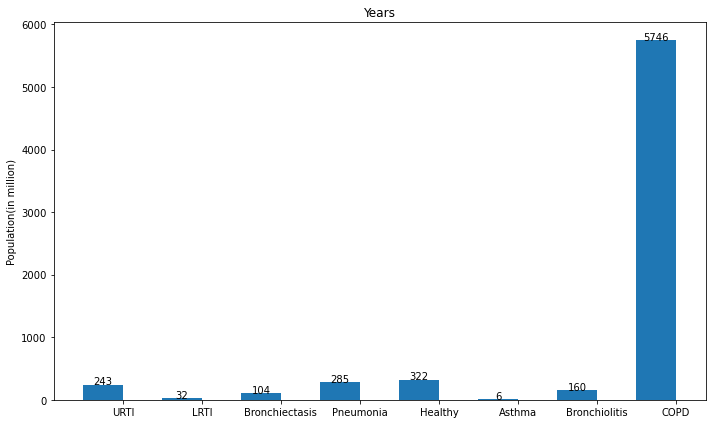

In [26]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
label = name
data = count
x = np.arange(len(label)) # the label locations
width = 0.5 # the width of the bars
fig, ax = plt.subplots()
ax.set_ylabel('Population(in million)')
ax.set_title('Years')
ax.set_xticks(x)
ax.set_xticklabels(label)
pps = ax.bar(x - width / 2, data, width, label='population')
for p in pps:
  height = p.get_height()
  ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10, s="{}".format(height), ha='center')
plt.show()

In [27]:
datas = {'Categories': name,
        'Data': count
        }
df = pd.DataFrame(datas, columns = ['Categories', 'Data'])
df.head(8)

,Categories,Data
0,URTI,243
1,LRTI,32
2,Bronchiectasis,104
3,Pneumonia,285
4,Healthy,322
5,Asthma,6
6,Bronchiolitis,160
7,COPD,5746
